In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        #initialize the properties
        self.narms = narms
        self.epsilon = epsilon
        self.Q = np.full(narms, Q0)# initialize rewards of each arms as Q0 
        self.steps = np.full(narms, 0) # used to count how many times each arm are used- update the Estimate value
        
    def play(self, tround, context=None):
        #epsilon probobility to randomly play other arms
        #(1 - epsilon) probobility to play the best arm
        if np.random.rand() < self.epsilon:
            arm = np.random.choice(np.arange(self.narms))
        else:
            max_arms = np.where(self.Q == np.max(self.Q))[0]
            arm = np.random.choice(max_arms) # tie-break randomly among max arms
        return arm + 1 #arm integer in {1, . . . , self.narms}
            
        
        
    def update(self, arm, reward, context=None):
        self.steps[arm - 1] += 1# arm used plus 1
        n = self.steps[arm - 1]# how many times a arm used
        value = self.Q[arm - 1]# Estimate value before update
        if value == np.inf:
            value = 0
        total_value = value*(n - 1) + reward# update the total Estimate value
        self.Q[arm - 1] = total_value/ n# get the updated average Estimate value
        
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q = np.full(narms, Q0)# initialize rewards of each arms as 0 
        self.steps = np.full(narms, 0) # used to count how many times each arm are used- update the Estimate value
        self.Q0 = Q0
    def play(self, tround, context=None):
        ubc_value = np.full(self.narms, self.Q0)# initialize value(rewords) at beginning at each play
        for arms in range(self.narms):
            if self.steps[arms] == 0:
                ubc_value[arms] = self.Q0
            else:
                bonus = np.sqrt(float(self.rho*np.log(tround))/self.steps[arms])
                ubc_value[arms] = self.Q[arms] + bonus
        max_arms = np.where(ubc_value == np.max(ubc_value))[0]
        arm = np.random.choice(max_arms) # tie-break randomly among max arms
       
        return arm + 1 #arm integer in {1, . . . , self.narms}
        
    def update(self, arm, reward, context=None):
        self.steps[arm - 1] += 1# arm used plus 1
        n = self.steps[arm - 1]# how many times a arm used
        value = self.Q[arm - 1]# Estimate value before update
        if value == np.inf:
            value = 0
        total_value = value*(n - 1) + reward# update the total Estimate value
        self.Q[arm - 1] = total_value/ n# get the updated average Estimate value
        
    

## 2. Off-Policy Evaluation

In [43]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    # here read dataset for evaluate
    log_data = np.loadtxt('dataset.txt')
    arms = log_data[:,0]
    rewards = log_data[:,1]
    contexts = log_data[:,2:]
    
    current_round = 0 #cunrrent round, as index of the array arms,current round in the log file
    tround = 1 #true round history,supplied round number
    total_rewards = [] # initialize the total rewards
    while tround < nrounds:
        arm =  mab.play(tround,contexts[current_round])
        if current_round == len(arms):
            break # end the offlineEvaluate when all data is used
        if arm == arms[current_round]:
            # it happens that the policy π chooses the same arm a as
            # the one that was selected by the logging policy, then the event is
            # retained, that is, added to the history, and the total payoff Rt updated
            mab.update(arm,rewards[current_round],contexts[current_round])
            total_rewards.append(rewards[current_round])
            tround += 1
            current_round += 1
        else:
            # Otherwise, if the policy π selects a different arm from the
            # one that was taken by the logging policy, then the event is entirely
            # ignored, and the algorithm proceeds to the next event without any
            # other change in its state
            current_round += 1
        
    return total_rewards
        
    

In [44]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26032540675844806


In [45]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))


UCB average reward 0.15519399249061328


## 3. Contextual Bandits

In [46]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha =alpha #initialize
        self.A = [] # initialize d-dimensional identity matrix
        self.B = [] # initialize d-dimensional zero vector
        for i in range(narms):
            self.A.append(np.mat(np.identity(ndims))) # initialize d-dimensional identity matrix
            self.B.append(np.mat(np.zeros((ndims, 1)))) # initialize d-dimensional zero vector
    
    def play(self, tround, context):
        lin_ubc_value = np.full(self.narms, 0.0)
        for i in range(self.narms):
            current_context = np.mat(context[i*10:i*10+10]).T
            theta = self.A[i].I.dot(np.mat(self.B[i])) # calculate θa
            base = theta.T.dot(current_context)[0][0] # θ⊤a * xt,a
            bonus = self.alpha * np.sqrt(current_context.T.dot(self.A[i].I).dot(current_context))[0][0]
            lin_ubc_value[i] = base + bonus
        max_arms = np.where(lin_ubc_value == np.max(lin_ubc_value))[0]
        arm = np.random.choice(max_arms) # tie-break randomly among max arms
        return arm + 1 #arm integer in {1, . . . , self.narms}
        
    
    def update(self, arm, reward, context):
        i = arm - 1
        chosen_context = np.mat(context[i*10:i*10+10]).T
        self.A[i] = self.A[i] + chosen_context.dot(chosen_context.T) # update d-dimensional identity matrix
        self.B[i] = self.B[i] + reward * chosen_context # update d-dimensional zero vector

    

In [47]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.5294117647058824


## 4. Evaluation
### 4.A.

C:\Users\hasee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\hasee\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\hasee\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


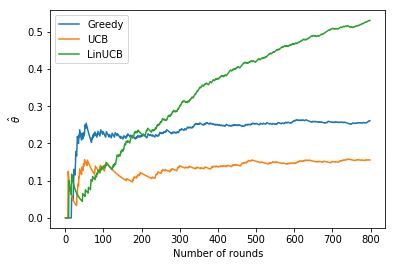

In [48]:
greedy_map = np.zeros(len(results_EpsGreedy))
ucb_map = np.zeros(len(results_UCB))
linucb_map = np.zeros(len(results_LinUCB))
greedy_rewards = 0
ucb_rewards = 0
linucb_rewards = 0 # initialize all data

for i in range(len(results_EpsGreedy)):
    greedy_rewards += results_EpsGreedy[i]
    greedy_map[i] = greedy_rewards / i # average rewards at each round

for i in range(len(results_UCB)):
    ucb_rewards += results_UCB[i]
    ucb_map[i] = ucb_rewards / i # average rewards at each round

for i in range(len(results_LinUCB)):
    linucb_rewards += results_LinUCB[i]
    linucb_map[i] = linucb_rewards / i # average rewards at each round

    
plt.plot(greedy_map, label = "Greedy")
plt.plot(ucb_map, label = "UCB")
plt.plot(linucb_map, label = "LinUCB")
plt.xlabel('Number of rounds')
plt.ylabel(r'$\hat{\theta}$')
plt.legend()
plt.show()

### 4.B.

In [51]:
gird = np.arange(0,1.01,0.01)# initialize the grid for sereach
max_average_reward = 0# initialize the reward
best_hyperparameters = 0# initialize the hyperparameters
rewards = []
round_reward = []
for i in gird:
    # run each mab for 10 times ,get the average rewards and compare with each others
    new_mab = LinUCB(10, 10, i)
    #tround = 0
    #round_reward = []
    #while tround < 10:
    results_LinUCB = offlineEvaluate(new_mab, arms, rewards, contexts, 800)
    round_reward.append(np.mean(results_LinUCB))
    #tround += 1
    #average_reward_i = np.mean(round_reward)
    #rewards.append(round_reward)
    #print ("the hyperparameters is ",i,"with the average ",average_reward_i)
    if np.mean(results_LinUCB) > max_average_reward:
        max_average_reward = np.mean(results_LinUCB)
        best_hyperparameters = i
print ("the best hyperparameters is ",best_hyperparameters,"with the average ",max_average_reward)

the best hyperparameters is  0.02 with the average  0.7309136420525657


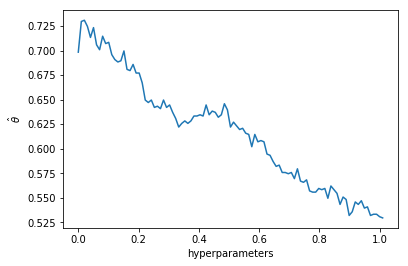

In [71]:
x = np.linspace(0, 1.01, 101)
y = round_reward
plt.plot(x,y)
plt.xlabel('hyperparameters')
plt.ylabel(r'$\hat{\theta}$')
plt.show()